#### Using the 2018 American Community Survey Data to Feature Engineer:
#### SQL code for retrival can be seen here:

'''

`WITH acs_2018 AS (
  SELECT geo_id, total_pop, housing_units, aggregate_travel_time_to_work, gini_index,
    bachelors_degree_or_higher_25_64, median_income

  FROM `bigquery-public-data.census_bureau_acs.zip_codes_2018_5yr`
),


acs_zipcode AS (
  SELECT *
  FROM acs_2018 a18
  JOIN `bigquery-public-data.geo_us_boundaries.zip_codes` geo
  ON a18.geo_id = geo.zip_code
) 

SELECT geo_id, zip_code, total_pop, housing_units, aggregate_travel_time_to_work, gini_index,
  bachelors_degree_or_higher_25_64, median_income
FROM acs_zipcode `

'''

In [2]:
import numpy as np
import pandas as pd
acs = pd.read_csv('~/Desktop/NYCDSA/Capstone/data/census_feats.csv')

In [6]:
# total units for housing in zip code / total population
acs['per_person_housing'] = acs['housing_units'] / acs['total_pop'] 
# total commute time for people in zip / total population
acs['mean_commute_time'] = acs['aggregate_travel_time_to_work'] / acs['total_pop']
# number of people in the zip code with a bachelors or higher / total population
acs['bachelors_ormore'] = acs['bachelors_degree_or_higher_25_64'] / acs['total_pop']

In [8]:
acs = acs.drop('housing_units',axis=1).drop('aggregate_travel_time_to_work',axis=1).\
drop('bachelors_degree_or_higher_25_64',axis=1)

In [10]:
zillow = pd.read_csv('~/Desktop/NYCDSA/Capstone/data/zillow-long-multifamily.csv')

In [26]:
zillow

,RegionID,SizeRank,State,City,Metro,CountyName,zipcodes,date,rent
0,61639,1,NY,New York,New York-Newark-Jersey City,New York County,10025,2010-09,2930.00
1,84654,2,IL,Chicago,Chicago-Naperville-Elgin,Cook County,60657,2010-09,1447.00
2,61637,3,NY,New York,New York-Newark-Jersey City,New York County,10023,2010-09,2797.00
3,91982,4,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,77494,2010-09,NaN
4,84616,5,IL,Chicago,Chicago-Naperville-Elgin,Cook County,60614,2010-09,1437.00
...,...,...,...,...,...,...,...,...,...
210288,90755,1857,TX,Dallas,Dallas-Fort Worth-Arlington,Dallas County,75202,2020-01,NaN
210289,94610,1858,UT,Ephraim,NaN,Sanpete County,84627,2020-01,1296.48
210290,84452,1859,IL,Oak Park,Chicago-Naperville-Elgin,Cook County,60301,2020-01,NaN
210291,94629,1860,UT,Mount Pleasant,NaN,Sanpete County,84647,2020-01,1221.00


In [44]:
df = zillow.merge(acs,how='left',left_on='zipcodes',right_on='zip_code')

In [45]:
nyc = df[df.City == 'New York']

In [46]:
# limit to one point in time just to assess features
nyc = nyc[nyc.date == '2018-01']
nyc = nyc.drop('Metro', axis =1).drop('City',axis=1).drop('State',axis=1)

In [49]:
nyc.CountyName = [x.replace(" County","") for x in nyc.CountyName]

In [68]:
nyc.set_index('zipcodes',inplace=True)

In [51]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()

In [79]:
nyc = nyc.dropna(axis=0, how='any', thresh=None, subset=None)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
target =  nyc['rent']
feats = nyc[['total_pop','gini_index','mean_commute_time','bachelors_ormore','median_income']]

In [82]:
Xtrain, Xtest, ytrain, ytest = train_test_split(feats,target)

In [83]:
ols.fit(Xtrain,ytrain)
print(f"Training R2: {ols.score(Xtrain,ytrain)}")
print(f"Test R2: {ols.score(Xtest,ytest)}")

Training R2: 0.7728663554603283
Test R2: 0.7685017978563359


In [86]:
Xtrain.columns.to_list()

['total_pop',
 'gini_index',
 'mean_commute_time',
 'bachelors_ormore',
 'median_income']

In [87]:
# code to check features for multicollinearity and plot:


continuous_features = Xtrain.columns.to_list()
scores = {}
ols = LinearRegression()
from sklearn.metrics import r2_score
for feature_name in continuous_features:
                df2     = Xtrain.copy()
                feature = df2[feature_name].copy()
                df2.drop(feature_name, axis=1, inplace=True)
                ols.fit(df2, feature)
                scores[feature_name] = ols.score(df2, feature)   

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

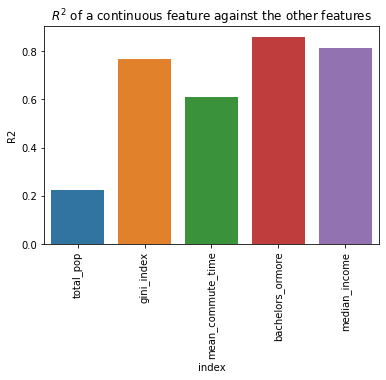

In [96]:
import seaborn as sns
sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.title('$R^2$ of a continuous feature against the other features')
plt.xticks(rotation = 90)
# we might have some multicollinearity

In [97]:
from sklearn.linear_model import Lasso
lasso = Lasso()
target =  nyc['rent']
feats = nyc[['total_pop','gini_index','mean_commute_time','bachelors_ormore','median_income']]

In [112]:
dummy_cols = pd.get_dummies(nyc['CountyName']).drop('Queens',axis=1)

In [117]:
feats2 = pd.concat((feats,dummy_cols), axis=1)

In [121]:
lasso.set_params(max_iter=10000, normalize=True)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [123]:
from sklearn.model_selection import GridSearchCV
grid_param = [{'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]}]
grid = GridSearchCV(estimator=lasso, param_grid=grid_param, cv=5, return_train_score=True)
# you can pass a number into CV or a cross-val object such as kfold
grid.fit(feats2,target)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,
                                    100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [158]:
grid_results = pd.DataFrame({'mean_test_R2':grid.cv_results_['mean_test_score'],
                             'mean_train_R2':grid.cv_results_['mean_train_score'],
                             'alpha':grid.cv_results_['param_alpha'],
                             'rank':grid.cv_results_['rank_test_score']
             })

In [167]:
grid_results[grid_results['rank'] == 1]

,mean_test_R2,mean_train_R2,alpha,rank
6,0.813644,0.861956,1,1


In [170]:
feats3 = feats2.copy()
feats3['total_pop'] = np.log(feats3['total_pop'])
feats3['median_income'] = np.log(feats3['median_income'])
feats3.head()

,total_pop,gini_index,mean_commute_time,bachelors_ormore,median_income,Bronx,Kings,New York,Richmond
zipcodes,,,,,,,,,
10025,11.438256,0.5968,15.548031,0.397446,11.361288,0,0,1,0
10023,11.041881,0.5604,15.426283,0.501241,11.778761,0,0,1,0
10002,11.225150,0.5838,13.679810,0.240609,10.487350,0,0,1,0
11226,11.515692,0.4631,20.663362,0.175414,10.859998,0,1,0,0
10467,11.549566,0.4810,18.367283,0.110043,10.519079,1,0,0,0


In [171]:
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
grid_param = [{'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]}]
grid = GridSearchCV(estimator=lasso, param_grid=grid_param, cv=5, return_train_score=True)

grid.fit(feats3,target)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,
                                    100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [172]:
grid_results = pd.DataFrame({'mean_test_R2':grid.cv_results_['mean_test_score'],
                             'mean_train_R2':grid.cv_results_['mean_train_score'],
                             'alpha':grid.cv_results_['param_alpha'],
                             'rank':grid.cv_results_['rank_test_score']
             })

In [174]:
grid_results[grid_results['rank'] == 1]

,mean_test_R2,mean_train_R2,alpha,rank
4,0.80989,0.865007,0.1,1
